##**Notebook PC#10 - Part 3 (convolutional)**

## Generative Adversarial Networks for the MNIST dataset.

Based on [this content](https://towardsdatascience.com/generative-adversarial-networks-bf4e809180b3), with code corrections.

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Ariel Góes de Castro <br>
**Aluno(a):** Francisco Germano Vogt

In [1]:
import tensorflow as tf
from tensorflow import keras

from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, LeakyReLU, Conv2D, Conv2DTranspose, UpSampling2D, ZeroPadding2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class GAN():
    def __init__(self, class_label):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.class_label = class_label

        optimizer = Adam(0.0002, 0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        self.generator = self.build_generator()

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        self.discriminator.trainable = False

        validity = self.discriminator(img)

        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        model = Sequential(name="GENERATOR")

        # foundation for 4x4 image
        n_nodes = 256 * 4 * 4
        model.add(Dense(n_nodes, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 256)))
        # upsample to 8x8
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 16x16
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 32x32
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # output layer
        model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential(name="DISCRIMINATOR")

        # normal
        model.add(Conv2D(64, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        # downsample
        model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # downsample
        model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # downsample
        model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # classifier
        model.add(Flatten())
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        (X_train, y_train), (_, _) = cifar10.load_data()

        # Filter the dataset for the specified class label
        X_train = X_train[y_train.flatten() == self.class_label]
        
        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.

        d_losses = []
        d_accuracies = []
        g_losses = []

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)

            d_losses.append(d_loss[0])
            d_accuracies.append(100 * d_loss[1])
            g_losses.append(g_loss)

            if epoch % 100 == 0:
                print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))

            if epoch % sample_interval == 0:
                self.sample_images(epoch)

        return d_losses, d_accuracies, g_losses

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig("cifar10_class_%d_epoch_%d_CONV.png" % (self.class_label, epoch))
        plt.close()

In [3]:
# Example: Train the GAN on class 3 (cats) of CIFAR-10
gan = GAN(class_label=3)
d_losses, d_accuracies, g_losses = gan.train(epochs=30001, batch_size=128, sample_interval=1000)

Model: "DISCRIMINATOR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)       

2024-05-30 20:01:45.224952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-30 20:01:45.228921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-30 20:01:45.229024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-30 20:01:45.229536: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

4/4 [==============================] - 1s 2ms/step


2024-05-30 20:01:47.342626: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-30 20:01:47.342854: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-30 20:01:47.342870: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-05-30 20:01:47.343152: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-30 20:01:47.343215: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


0 [D loss: 0.700510, acc.: 12.89%] [G loss: 0.691293]
1/1 [==============================] - 0s 64ms/step


2024-05-30 20:01:48.100983: W tensorflow/core/kernels/conv_ops_gpu.cc:336] None of the algorithms provided by cuDNN frontend heuristics worked; trying fallback algorithms.  Conv: batch: 128
in_depths: 128
out_depths: 3
in: 32
in: 32
data_format: 1
filter: 3
filter: 3
filter: 128
dilation: 1
dilation: 1
stride: 1
stride: 1
padding: 1
padding: 1
dtype: DT_FLOAT
group_count: 1
device_identifier: "NVIDIA GeForce RTX 2080 Ti sm_7.5 with 11544035328B RAM and 68 cores"
version: 1

2024-05-30 20:01:48.151337: W tensorflow/core/kernels/conv_ops_gpu.cc:336] None of the algorithms provided by cuDNN frontend heuristics worked; trying fallback algorithms.  Conv: batch: 128
in_depths: 128
out_depths: 256
in: 8
in: 8
data_format: 1
filter: 4
filter: 4
filter: 128
dilation: 1
dilation: 1
stride: 2
stride: 2
padding: 1
padding: 1
dtype: DT_FLOAT
group_count: 1
device_identifier: "NVIDIA GeForce RTX 2080 Ti sm_7.5 with 11544035328B RAM and 68 cores"
version: 1



4/4 [==============================] - 0s 1ms/step
100 [D loss: 0.390957, acc.: 87.11%] [G loss: 2.384181]
4/4 [==============================] - 0s 1ms/step
200 [D loss: 0.287401, acc.: 89.45%] [G loss: 2.515499]
4/4 [==============================] - 0s 1ms/step
300 [D loss: 0.640575, acc.: 63.67%] [G loss: 1.282322]
4/4 [==============================] - 0s 1ms/step
400 [D loss: 0.634107, acc.: 66.80%] [G loss: 1.010324]
4/4 [==============================] - 0s 1ms/step
500 [D loss: 0.706083, acc.: 58.98%] [G loss: 1.271986]
4/4 [==============================] - 0s 1ms/step
600 [D loss: 0.429777, acc.: 90.23%] [G loss: 1.329539]
4/4 [==============================] - 0s 1ms/step
700 [D loss: 0.567714, acc.: 79.30%] [G loss: 0.993399]
4/4 [==============================] - 0s 1ms/step
800 [D loss: 0.501058, acc.: 80.08%] [G loss: 1.428918]
4/4 [==============================] - 0s 1ms/step
900 [D loss: 0.532209, acc.: 73.83%] [G loss: 1.033350]
4/4 [==============================] 

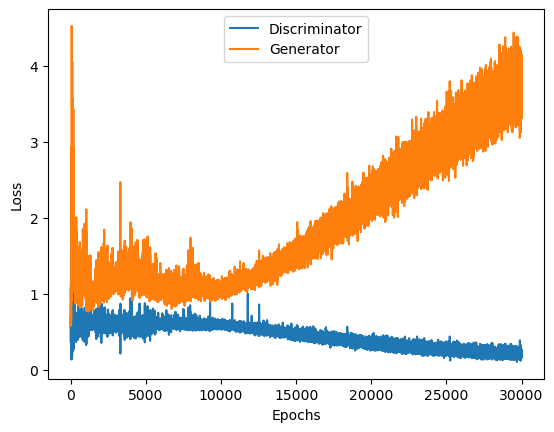

In [4]:
# Visualize losses
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

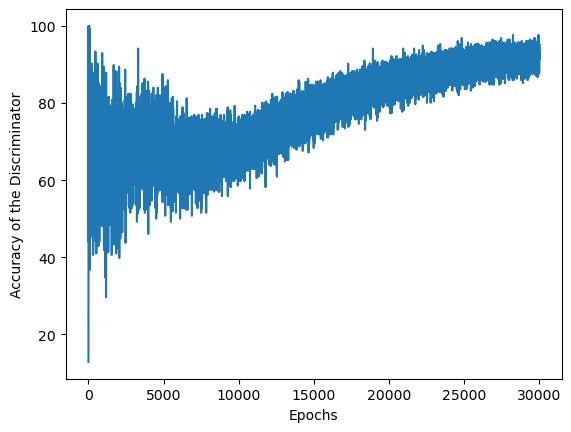

In [5]:
# Visualize accuracy
plt.plot(d_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy of the Discriminator')
plt.show()